In [2]:
# This notebook is a clone of the work from Marco David and Florian Mehats (https://arxiv.org/pdf/2106.11753). Here we merely
# run the code from their GitHub (repo cloned below) and begin to think of avenues for using this SHNN architecture for other problems

In [ ]:
# Setting up the environment (directory, repo, requirements)
!git clone https://github.com/SpaceAbleOrg/symplectic-hnn.git
%cd /content/symplectic-hnn


# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install -c conda-forge mamba -y
# from google.colab import files
# uploaded = files.upload()

# !mamba env create -f environment.yml
# !mamba activate symplectic-hnn


Cloning into 'symplectic-hnn'...
remote: Enumerating objects: 534, done.
remote: Counting objects: 100% (534/534), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 534 (delta 273), reused 523 (delta 266), pack-reused 0 (from 0)
Receiving objects: 100% (534/534), 7.75 MiB | 5.15 MiB/s, done.
Resolving deltas: 100% (273/273), done.
/content/symplectic-hnn


In [ ]:
!unzip release-v1.0.zip

Archive:  release-v1.0.zip
   creating: release-1.0/
   creating: release-1.0/experiment-double-pendulum/
  inflating: __MACOSX/release-1.0/._experiment-double-pendulum  
  inflating: release-1.0/.DS_Store   
  inflating: __MACOSX/release-1.0/._.DS_Store  
   creating: release-1.0/experiment-pendulum/
  inflating: __MACOSX/release-1.0/._experiment-pendulum  
   creating: release-1.0/experiment-spring/
  inflating: __MACOSX/release-1.0/._experiment-spring  
  inflating: release-1.0/experiment-double-pendulum/double-pendulum-h0.2.shnndata  
  inflating: __MACOSX/release-1.0/experiment-double-pendulum/._double-pendulum-h0.2.shnndata  
  inflating: release-1.0/experiment-double-pendulum/double-pendulum-h0.4-midpoint.tar  
  inflating: __MACOSX/release-1.0/experiment-double-pendulum/._double-pendulum-h0.4-midpoint.tar  
  inflating: release-1.0/experiment-double-pendulum/double-pendulum-h0.2-euler-symp.tar  
  inflating: __MACOSX/release-1.0/experiment-double-pendulum/._double-pendulum-h0.2

In [3]:
# train on generated pendulum data using symplectic euler method as the loss function
!python train.py pendulum --loss_type euler-symp

Traceback (most recent call last):
  File "train.py", line 155, in <module>
    train_main(get_args())
  File "c:\Users\AvinashKumar\Documents\GitHub\symplectic-hnn\model\args.py", line 69, in get_args
    return UpdatableNamespace.get(args)
  File "c:\Users\AvinashKumar\Documents\GitHub\symplectic-hnn\model\args.py", line 15, in get
    return UpdatableNamespace() | obj
  File "c:\Users\AvinashKumar\Documents\GitHub\symplectic-hnn\model\args.py", line 19, in __or__
    return UpdatableNamespace(**(self.__dict__ | other.__dict__))
TypeError: unsupported operand type(s) for |: 'dict' and 'dict'


In [ ]:
# Plotting Hamiltonian error

import os, sys
# project_root = os.path.dirname(os.path.abspath(''))
project_root = os.getcwd()
sys.path.append(project_root)

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# # Project Imports
# from train import setup
# from utils import save_path
# from metrics import calc_herr

import importlib.util

# Import setup from train.py
spec_train = importlib.util.spec_from_file_location("setup", "train.py")
train = importlib.util.module_from_spec(spec_train)
spec_train.loader.exec_module(train)

# Import save_path from utils.py
spec_utils = importlib.util.spec_from_file_location("save_path", "utils.py")
utils = importlib.util.module_from_spec(spec_utils)
spec_utils.loader.exec_module(utils)

# Import calc_herr from metrics.py
spec_metrics = importlib.util.spec_from_file_location("calc_herr", "metrics.py")
metrics = importlib.util.module_from_spec(spec_metrics)
spec_metrics.loader.exec_module(metrics)

# Now you can use the imported functions
setup_function = train.setup
save_path_function = utils.save_path
calc_herr_function = metrics.calc_herr


hs = np.array([0.8, 0.4, 0.2, 0.1, 0.05])
methods = ['euler-forw', 'euler-symp', 'midpoint']

SAVE_DIR_PREFIX = '/results/experiment-'

#check to see if importing these functions worked
print('setup_function:', setup_function)
print('save_path_function:', save_path_function)
print('calc_herr_function:', calc_herr_function)

setup_function: <function setup at 0x7f33cd2b7a30>
save_path_function: <function save_path at 0x7f33041b3be0>
calc_herr_function: <function calc_herr at 0x7f33041c8310>


In [ ]:
# Outsource calculations prior to plotting

def plot_stderr(axes, hs, means, stderrs, label):
    axes.errorbar(hs, means, yerr=stderrs, fmt='o-', label=label)

def plot_quartiles(axes, hs, means, quartiles, label):
    axes.plot(hs, means, 'o-', label=label)
    axes.fill_between(hs, quartiles[:, 0], quartiles[:, 1], alpha=0.25)

plot_fct = plot_quartiles

def plot_herr(axes, args, legend_loc='lower right', annotate_slopes=False, clipy=True, omega_m=True, save_dir_prefix=SAVE_DIR_PREFIX):
    # Plot grey guides of y = px, indicating errors of order p
    axes.loglog(hs, hs, '--', color='grey', linewidth=1)
    axes.loglog(hs, hs**2, '--', color='grey', linewidth=1)

    # Plot errors for each method
    for method in methods:
        err = calc_herr_function(args | {'loss_type': method}, hs, omega_m=omega_m, save_dir_prefix=save_dir_prefix)

        # CHOICE: plot_fct as assigned above will result in either of the two results below
        plot_fct(axes, hs, err[:, 0], err[:, 1:], r'$\varepsilon_H$ ' + print_method[method])
        #plot_stderr(axes, hs, err[:, 0], err[:, 1], r'$\varepsilon_H$ ' + print_method[method])
        #plot_quartiles(axes, hs, err[:, 0], err[:, 1:], r'$\varepsilon_H$ ' + print_method[method])

        # DEBUGGING:
        # for i, h in enumerate(hs):
        #     print(f"h = {h}, method = {method}: error = {err[i, 0]:.2f} ± {err[i, 1]:.2f}")

    # Plot errors for the corrected symplectic Euler
    err = calc_herr_function(args | {'loss_type': 'euler-symp'}, hs, corrected=True, save_dir_prefix=save_dir_prefix)
    plot_fct(axes, hs, err[:, 0], err[:, 1:], r'$\varepsilon_H$ corrected ' + print_method['euler-symp'])

    # SETUP PLOT META VARIABLES
    axes.set_xlabel("Discretization Step $h$")  # possible kwargs: fontsize=14
    axes.set_ylabel(r"Error $\varepsilon$")  # possible kwargs: rotation=0, fontsize=14
    axes.set_xticks(hs)
    axes.set_xticklabels(map(str, hs))
    axes.set_title(f"{print_name[args.name]}: Hamiltonian Error")  # (fontsize=14) possible kwarg: pad=10

    if clipy:
        axes.set_ylim(.5e-4, 2)

    if annotate_slopes: # (fontsize=10)
        axes.text(0.14, 0.14-0.02, r'$\varepsilon \in \mathcal O(h)$',
                  color='grey', rotation=15, verticalalignment='bottom', horizontalalignment='center')
        axes.text(0.15, 0.15**2-0.005, r'$\varepsilon \in \mathcal O(h^2)$',
                  color='grey', rotation=25, verticalalignment='bottom', horizontalalignment='center')

    legend = axes.legend(loc=legend_loc)
    legend.get_frame().set_facecolor('0.8')  # fill the legend dark grey
    legend.get_frame().set_linewidth(0.0)  # remove the black border

In [ ]:
!mkdir -p finance

In [ ]:
!touch "finance/data.py"

In [ ]:
# install LaTeX
!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x libavalon-framework-

In [ ]:
import os
from google.colab import files

# Define the base directory
base_dir = "/content/symplectic-hnn"

# Create the results directory and subdirectories
results_dir = os.path.join(base_dir, "results")
os.makedirs(results_dir, exist_ok=True)
experiment_dirs = ["experiment-spring", "experiment-pendulum", "experiment-double-pendulum"]

for experiment in experiment_dirs:
    os.makedirs(os.path.join(results_dir, experiment), exist_ok=True)

# Upload and move files to their respective directories
# Upload files for experiment-spring
print("Upload files for experiment-spring")
uploaded_spring = files.upload()
for filename in uploaded_spring.keys():
    os.rename(filename, os.path.join(results_dir, "experiment-spring", filename))

# Upload files for experiment-pendulum
print("Upload files for experiment-pendulum")
uploaded_pendulum = files.upload()
for filename in uploaded_pendulum.keys():
    os.rename(filename, os.path.join(results_dir, "experiment-pendulum", filename))

# Upload files for experiment-double-pendulum
print("Upload files for experiment-double-pendulum")
uploaded_double_pendulum = files.upload()
for filename in uploaded_double_pendulum.keys():
    os.rename(filename, os.path.join(results_dir, "experiment-double-pendulum", filename))

# Verify the directory structure and uploaded files
!ls -R /content/symplectic-hnn/results


/content/symplectic-hnn/results:
experiment-double-pendulum  experiment-pendulum  experiment-spring

/content/symplectic-hnn/results/experiment-double-pendulum:

/content/symplectic-hnn/results/experiment-pendulum:

/content/symplectic-hnn/results/experiment-spring:


/content/symplectic-hnn/model/hnn.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(save_path(args), map_location=torch.device('cpu'))


0.07052706781131866 0.15353506544202178


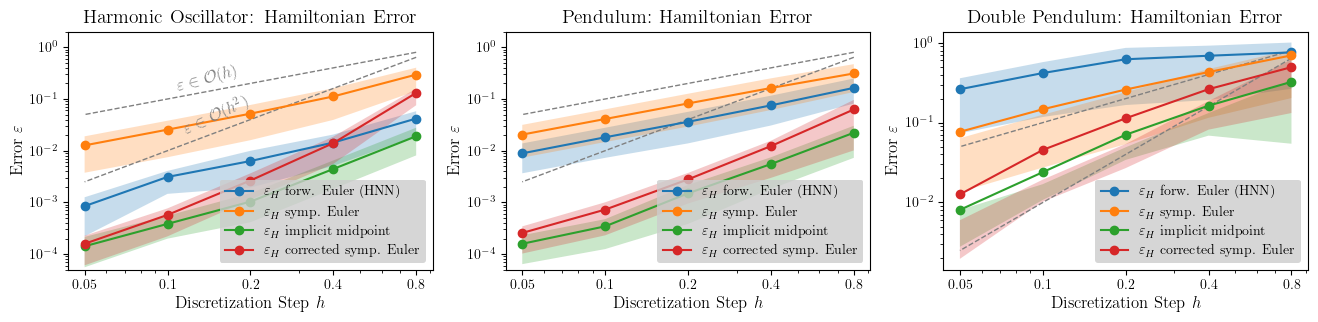

In [ ]:
# Plotting code
# !apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

from visualize import *
mpl.rcParams.update(params)
%matplotlib inline

# Test on single data point
from metrics import hamiltonian_error_sampled
from model.hnn import HNN
args = default_args | {'name': 'double-pendulum', 'loss_type': 'midpoint', 'h': 0.2}
args = setup_function(args, save_dir_prefix='/results/experiment-')
model, args = HNN.load(args, cpu=True)
data_loader = args.data_class(args.h, args.noise)
H_err = np.abs(hamiltonian_error_sampled(model, data_loader, omega_m=True))
print(np.mean(H_err), np.std(H_err))

# PLOT ALL TOGETHER
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(16, 5*golden_ratio))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

plot_herr(ax1, default_args | {'name': 'spring'}, annotate_slopes=True, save_dir_prefix='/results/experiment-')
plot_herr(ax2, default_args | {'name': 'pendulum'}, save_dir_prefix='/results/experiment-')
plot_herr(ax3, default_args | {'name': 'double-pendulum'}, clipy=False, save_dir_prefix='/results/experiment-')

#plot_herr(ax3, default_args | {'name': 'twobody'})
#plot_herr(ax4, default_args | {'name': 'fput'})

fig.savefig("hamiltonian-error.pdf", format='pdf', bbox_inches='tight')